# Part I: Exploratory Data Analysis (EDA)

In this notebook, we will prepare the hippocampus dataset by exploring and transforming the data as necessary to remove any potential noise.

### Imports

In [36]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil

from pathlib import Path
from typing import Iterable

### Global variables

In [38]:
DATA_PATH: Path = Path("../data")
IMAGES_PATH: Path = DATA_PATH.joinpath("training_set/images")
MASKS_PATH: Path = DATA_PATH.joinpath("training_set/masks")
SAMPLES_REMOVE: Iterable[str] = []

## 1. Load and plot NIFTI images

In [39]:
image_files = {
    f.with_suffix("").with_suffix("").stem.split("_")[1]: f
    for f in sorted(IMAGES_PATH.glob("*.nii.gz"))
}
print(f"Found {len(image_files)} images in total.")
mask_files = {
    f.with_suffix("").with_suffix("").stem.split("_")[1]: f
    for f in sorted(MASKS_PATH.glob("*.nii.gz"))
}
print(f"Found {len(mask_files)} image masks in total.")

Found 263 images in total.
Found 262 image masks in total.


Plotting image and mask for sample '010'.
Shape of image array: (35, 51, 35).
Shape of label array: (35, 51, 35).
Total number of voxels: 62475.



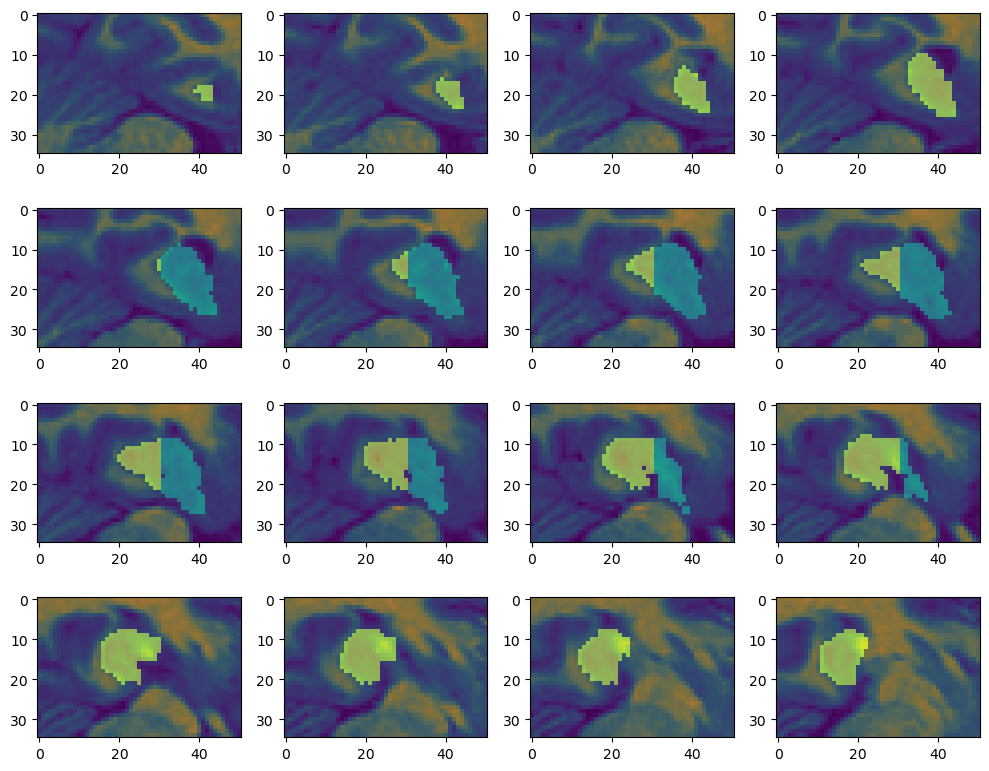

In [40]:
print(f"Plotting image and mask for sample '010'.")
nifti_img = nib.load(image_files["001"])
nifti_mask = nib.load(mask_files["001"])
print(
    f"Shape of image array: {nifti_img.shape}.\n"
    f"Shape of label array: {nifti_mask.shape}.\n"
    f"Total number of voxels: {np.prod(nifti_img.shape)}.\n"
)

fig, axes = plt.subplots(4, 4, figsize=(10, 8))

for i, ax in enumerate(axes.flat):
    ax.imshow(nifti_img.get_fdata()[:, :, 5 + i])
    ax.imshow(nifti_mask.get_fdata()[:, :, 5 + i], alpha=0.5)

plt.tight_layout()

The following image shows the same sample visualized using 3DSlicer with volume estimation.

![3D slicer Test](../images/3d_slicer_test.png)

## 2. Identify problematic sample files

### 2.1. What sample has no mask?

In [41]:
no_mask_samples = list(set(image_files.keys()) - set(mask_files.keys()))
print(
    f"Samples {no_mask_samples} have no assigned mask "
    "and will thus be removed from the dataset."
)
SAMPLES_REMOVE.extend(no_mask_samples)
valid_ids = set(image_files.keys()).intersection(set(mask_files.keys()))

Samples ['118'] have no assigned mask and will thus be removed from the dataset.


### 2.2. Are the images and their corresponding masks of the same shape?

In [42]:
shapes_equality = pd.Series(
    {
        sample_id: nib.load(image_files[sample_id]).shape
        == nib.load(mask_files[sample_id]).shape
        for sample_id in valid_ids
    }
)
mismatched_samples = shapes_equality[~shapes_equality].index.tolist()
print(
    f"Samples {mismatched_samples} have an image-mask shape mismatch "
    "and will thus be removed from the dataset."
)
SAMPLES_REMOVE.extend(mismatched_samples)
valid_ids = valid_ids.difference(set(SAMPLES_REMOVE))

Samples ['010', '281'] have an image-mask shape mismatch and will thus be removed from the dataset.


## 3. Explore NIFTI header information

In order to measure the physical volume of hippocampi, we need to understand the relationship between the sizes of our voxels and the physical world. [Here](https://brainder.org/2012/09/23/the-nifti-file-format/) is a reference resource for the various fields.

In [43]:
nifti_img = nib.load(image_files["001"])
print(np.array(nifti_img.header.keys()))

['sizeof_hdr' 'data_type' 'db_name' 'extents' 'session_error' 'regular'
 'dim_info' 'dim' 'intent_p1' 'intent_p2' 'intent_p3' 'intent_code'
 'datatype' 'bitpix' 'slice_start' 'pixdim' 'vox_offset' 'scl_slope'
 'scl_inter' 'slice_end' 'slice_code' 'xyzt_units' 'cal_max' 'cal_min'
 'slice_duration' 'toffset' 'glmax' 'glmin' 'descrip' 'aux_file'
 'qform_code' 'sform_code' 'quatern_b' 'quatern_c' 'quatern_d' 'qoffset_x'
 'qoffset_y' 'qoffset_z' 'srow_x' 'srow_y' 'srow_z' 'intent_name' 'magic']


### 3.1. Confirm that our images are in NIFTI format

In [44]:
nifti_img.header_class

nibabel.nifti1.Nifti1Header

### 3.2. How many bits per pixel are used?

In [45]:
nifti_img.header["bitpix"]

array(8, dtype=int16)

### 3.3. What are the units of measurement?

In [46]:
nifti_img.header["xyzt_units"]  # 10 (2) is mm

array(10, dtype=uint8)

The unit of measurements is milimiters.

### 3.4. Do we have a regular grid? What are grid spacings?

In [47]:
nifti_img.header["pixdim"]

array([1., 1., 1., 1., 1., 0., 0., 0.], dtype=float32)

Indices 1, 2 y 3 are voxel dimensions over the x, y and z axes, respectively. We can see that the size of a voxel is 1 mm<sup>3</sup>.

### 3.5. What dimensions represent axial, sagittal, and coronal slices? How do you know?

In [48]:
nifti_img.header["sform_code"]

array(1, dtype=int16)

In [49]:
max_min_values = []
for img_file in image_files.values():
    nifti_array = nib.load(img_file).get_fdata()
    max_min_values.append((nifti_array.min(), nifti_array.max()))

The code above is for *Scanner-based anatomical coordinates*.

The most visible improvement of the nifti format over the previous analyze format is the ability to unambiguously store information orientation. The file standard assumes that the voxel coordinates refer to the center of each voxel, rather than at any of its corners. The world coordinate system is assumed to be **RAS**: +x is Right, +y is Anterior and +z is Superior.

Hence, each coordinate means the following:

- X dimension is sagittal (from left to right).
- Y dimension is coronal (from posterior to anterior).
- Z dimension is axial (from inferior to superior).

### 3.6. Example calculation of a mask volume

In [50]:
nifti_mask = nib.load(mask_files["001"])
nifti_mask_array = nifti_mask.get_fdata()
print(f"Mask of sample 001 has a size of {np.sum(nifti_mask_array != 0)} mm^3")

Mask of sample 001 has a size of 2948 mm^3


## 4. Explore distribution of volume sizes

We plot a histogram of all volumes that we have in our dataset and see how our dataset measures against a slice of a normal population represented by the chart below.

<img src="../images/nomogram_fem_right.svg" width=400 align=left>

### 4.1. Plot mask volume histogram

In [51]:
mask_volumes = pd.Series(
    {
        sample_id: np.sum(nib.load(mask_file).get_fdata() != 0)
        for sample_id, mask_file in mask_files.items()
    }
)

<Axes: ylabel='Frequency'>

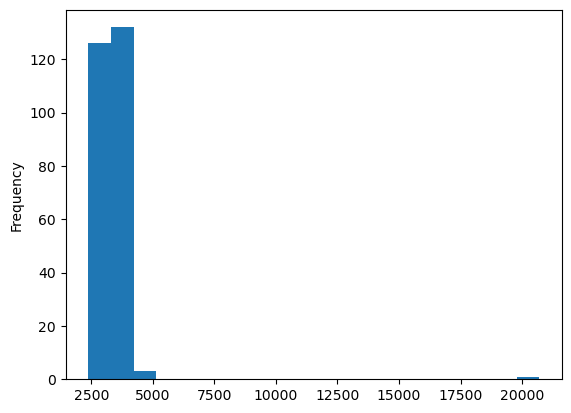

In [52]:
mask_volumes.plot(kind="hist", bins=20)

### 4.2. Identify outliers

In [53]:
mask_volumes_sorted = mask_volumes.sort_values(ascending=False)
mask_volumes_sorted.head(5)

281    20702
368     4401
242     4383
006     4263
367     4151
dtype: int64

In [54]:
outlier_sample = mask_volumes_sorted.index[0]
SAMPLES_REMOVE.append(outlier_sample)
valid_ids = valid_ids.difference(set(SAMPLES_REMOVE))

There is at least one obvious outlier. Sample *281* has a mask whose volume is nearly 5 times bigger than the second biggest volume, so we can safely assume that this sample is an outlier.

### 4.3. Plot again without outliers

<Axes: ylabel='Frequency'>

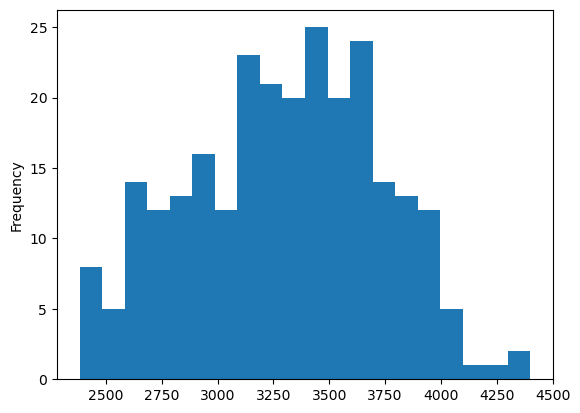

In [55]:
mask_volumes[mask_volumes.index != outlier_sample].plot(kind="hist", bins=20)

In the real world we would have precise information about the ages and conditions of our patients, and understanding how our dataset measures against population norm would be the integral part of clinical validation that we talked about in last lesson. Unfortunately, we do not have this information about this dataset, so we can only guess why it measures the way it is. If you would like to explore further, you can use the [calculator from HippoFit project](http://www.smanohar.com/biobank/calculator.html) to see how our dataset compares against different population slices.

## 5. Store cleaned dataset in separate directory

In [56]:
new_images_root = (
    DATA_PATH.joinpath("output").joinpath("cleaned_data").joinpath("images")
)
new_images_root.mkdir(exist_ok=True, parents=True)

new_masks_root = DATA_PATH.joinpath("output").joinpath("cleaned_data").joinpath("masks")
new_masks_root.mkdir(exist_ok=True, parents=True)

In [57]:
for sample_id in valid_ids:
    shutil.copy(image_files[sample_id], new_images_root.joinpath(f"{sample_id}.nii.gz"))
    shutil.copy(mask_files[sample_id], new_masks_root.joinpath(f"{sample_id}.nii.gz"))

## 6. Final remarks

In this section we have inspected a dataset of MRI scans and related segmentations, represented as NIFTI files. We have visualized some slices, and understood the layout of the data. We have inspected file headers to understand what how the image dimensions relate to the physical world and we have understood how to measure our volume. We have then inspected dataset for outliers, and have created a clean set that is ready for consumption by our ML algorithm.

In the next section we will create training and testing pipelines for a UNet-based machine learning model, run and monitor the execution, and will produce test metrics. This will arm us with all we need to use the model in the clinical context and reason about its performance!